## 0. Getting Setup

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [5]:
def download_data(source : str,
                  destination : str,
                  remove_source: bool = True):
  """Downloads a zipped dataset from source and unzips to destination.
    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
  """
  import os
  import pathlib
  import requests
  import zipfile

  data_path = pathlib.Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

  target_file = pathlib.Path(source).name
  with open(data_path /target_file, "wb") as f:
    request = requests.get(source)
    print(f"[INFO] Downloading {target_file} from {source}...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
    print(f"[INFO] Unzipping {target_file} data...")
    zip_ref.extractall(image_path)

  if remove_source:
            os.remove(data_path / target_file)

  return image_path

In [6]:
data_20_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination = "pizza_steak_sushi_20_percent",
                                     )
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [7]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model with EffNetB2

### 2.1 Creating a function to make an EffNetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes : int = 3, seed : int = 42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for params in model.parameters():
    params.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 169MB/s]


In [10]:
summary(model = effnetb2,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 2.2 Creating DataLoaders for EffNetB2

In [11]:
import os
num_workers = os.cpu_count()
def create_dataLoaders(train_dir: str,
                       test_dir: str,
                       transform : torchvision.transforms.Compose,
                       batch_size: int,
                       num_workers: int = num_workers):
  train_dataset = torchvision.datasets.ImageFolder(train_dir, transform = transform)
  test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = transform)

  classes = train_dataset.classes

  train_dataLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
  test_dataLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)

  return train_dataLoader, test_dataLoader, classes

In [12]:
batch_size = 32
effnetb2_train_dataLoader, effnetb2_test_dataLoader, effnetb2_classes = create_dataLoaders(train_dir, test_dir, effnetb2_transforms, batch_size = batch_size)

In [13]:
effnetb2_train_dataLoader, effnetb2_test_dataLoader, effnetb2_classes

(<torch.utils.data.dataloader.DataLoader at 0x7ef0507c5310>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Training EffNetB2

In [14]:
optimizer = torch.optim.Adam(effnetb2.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
def train_step(model: torch.nn.Module,
               dataLoader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataLoader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    train_logits = model(X)
    loss = loss_fn(train_logits, y)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

    train_preds = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)
    train_acc += (train_preds == y).sum().item() / len(train_logits)

  train_loss = train_loss / len(dataLoader)
  train_acc = train_acc / len(dataLoader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device
              ):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataLoader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_preds = torch.argmax(test_logits, dim = 1)
      test_acc += ((test_preds == y).sum().item() / len(test_preds))
    test_loss = test_loss / len(dataLoader)
    test_acc = test_acc / len(dataLoader)

  return test_loss, test_acc

def train_test(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               test_dataLoader : torch.utils.data.DataLoader,
               optimizer : torch.optim.Optimizer,
               loss_fn : torch.nn.Module,
               epochs : int,
               device : torch.device):

  results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

  model.to(device)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       dataLoader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device
                                       )
    test_loss, test_acc = test_step(model = model,
                                    dataLoader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [16]:
effnetb2_results = train_test(model = effnetb2,
           train_dataLoader = effnetb2_train_dataLoader,
           test_dataLoader = effnetb2_test_dataLoader,
           optimizer = optimizer,
           loss_fn = loss_fn,
           epochs = 5,
           device = device)

effnetb2_results

Epoch: 1 | train_loss: 0.9677 | train_acc: 0.5417 | test_loss: 0.7279 | test_acc: 0.9437
Epoch: 2 | train_loss: 0.7054 | train_acc: 0.8521 | test_loss: 0.5700 | test_acc: 0.9500
Epoch: 3 | train_loss: 0.5679 | train_acc: 0.8771 | test_loss: 0.4896 | test_acc: 0.9256
Epoch: 4 | train_loss: 0.5103 | train_acc: 0.8792 | test_loss: 0.4172 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.4319 | train_acc: 0.8979 | test_loss: 0.3750 | test_acc: 0.9597


{'train_loss': [0.9677491227785746,
  0.7054300586382548,
  0.5679320971171061,
  0.5103442589441936,
  0.43191425999005634],
 'train_acc': [0.5416666666666666,
  0.8520833333333333,
  0.8770833333333333,
  0.8791666666666667,
  0.8979166666666667],
 'test_loss': [0.7278638362884522,
  0.5699584007263183,
  0.48962814211845396,
  0.41724650263786317,
  0.374985808134079],
 'test_acc': [0.94375,
  0.95,
  0.9255681818181818,
  0.9443181818181818,
  0.959659090909091]}

### 2.4 Visualize Loss And Acc Values

In [17]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label = "train_acc")
  plt.plot(epochs, test_acc, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

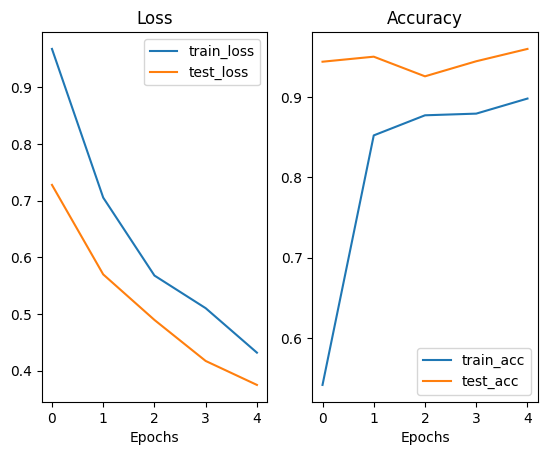

In [18]:
plot_loss_curves(effnetb2_results)

### 2.5 Saving EffnetB2

In [19]:
import pathlib
def save_model(model: torch.nn.Module,
               target_dir : str,
               model_name : str):

  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents = True, exist_ok = True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model name should end with '.pth' or '.pt'."

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}.")
  torch.save(obj = model.state_dict(),
             f =  model_save_path)

save_model(model = effnetb2, target_dir = "models", model_name = "09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth.


### 2.6 Checking the size of EffNetB2 feature extractor

In [20]:
import pathlib
pretrained_effnetb2_model_size = pathlib.Path("models/09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 2.7 Collecting EffNetB2 feature extractor stats

In [21]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
effnetb2_stats = {"test_loss" : effnetb2_results["test_loss"][-1],
                  "test_acc" : effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.374985808134079,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. FoodVision Mini model with ViT

In [23]:
def create_vit_b_16_model(num_classes:int=3, seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads  = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [24]:
vit, vit_transforms = create_vit_b_16_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.8MB/s]


In [25]:
summary(model = vit,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [26]:
vit_train_dataLoader, vit_test_dataLoader, vit_classes = create_dataLoaders(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            transform = vit_transforms,
                                                                            batch_size = 32)

vit_train_dataLoader, vit_test_dataLoader, vit_classes

(<torch.utils.data.dataloader.DataLoader at 0x7ef0503aa190>,
 ['pizza', 'steak', 'sushi'])

In [27]:
optimizer = torch.optim.Adam(vit.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

vit_results = train_test(model = vit,
                         train_dataLoader = vit_train_dataLoader,
                         test_dataLoader = vit_test_dataLoader,
                         optimizer = optimizer,
                         loss_fn = loss_fn,
                         epochs = 5,
                         device = device)

Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722


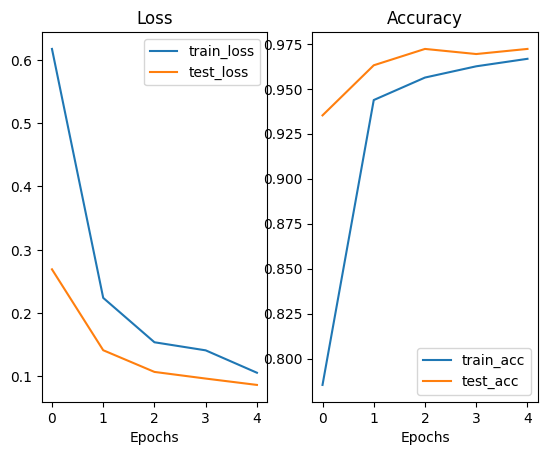

In [28]:
plot_loss_curves(vit_results)

In [29]:
save_model(model = vit, target_dir = "models", model_name = "09_pretrained_vit_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth.


In [30]:
pretrained_vitb16_model_size = pathlib.Path("models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT_B_16 feature extractor model size: {pretrained_vitb16_model_size} MB")

Pretrained ViT_B_16 feature extractor model size: 327 MB


In [31]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [32]:
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "number_of_parameters" : vit_total_params,
             "model_size (MB)": pretrained_vitb16_model_size}

vit_stats

{'test_loss': 0.0865598407573998,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 4. Creating a function to make predictions across the test dataset

In [33]:
from PIL import Image
import random
test_data_paths = list(pathlib.Path(test_dir).glob("*/*.jpg"))

In [34]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in paths:

    pred_dict = {}

    class_name = path.parent.stem
    pred_dict["image_path"] = path
    pred_dict["class_name"] = class_name

    start_time = timer()

    image = Image.open(path)

    image_transformed = transform(image).unsqueeze(dim = 0).to(device)

    model.eval()

    with torch.inference_mode():
      y_logits = model(image_transformed)
      y_params = torch.softmax(y_logits, dim = 1)
      y_preds = torch.argmax(y_params, dim = 1)
      pred_class = class_names[y_preds]

      pred_dict["pred_prob"] = y_params.max().cpu().item()
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_pred"] = round((end_time - start_time), 4)

      pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

In [35]:
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names = effnetb2_classes)

In [36]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8515026569366455,
  'pred_class': 'pizza',
  'time_for_pred': 0.079,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8612781763076782,
  'pred_class': 'pizza',
  'time_for_pred': 0.0223,
  'correct': True}]

In [37]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.851503,pizza,0.0790,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.861278,pizza,0.0223,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.588777,pizza,0.0233,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.880927,pizza,0.0216,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.720146,pizza,0.0243,True


In [38]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [39]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0213 seconds


In [40]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.374985808134079,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0213)}

In [41]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=vit_classes)

In [42]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9981972575187683,
  'pred_class': 'pizza',
  'time_for_pred': 0.0308,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9975270628929138,
  'pred_class': 'pizza',
  'time_for_pred': 0.0283,
  'correct': True}]

In [43]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.998197,pizza,0.0308,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.997527,pizza,0.0283,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.983935,pizza,0.0280,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.997741,pizza,0.0279,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.998416,pizza,0.0281,True


In [44]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,146
False,4


In [45]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.0202 seconds


In [46]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.0865598407573998,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.0202)}

## 5. Comparing model results, prediction times and size

In [47]:
dataframe = pd.DataFrame([effnetb2_stats, vit_stats])
dataframe["model"] = ["EffNet_B2", "ViT_B_16"]
dataframe["test_acc"] = round(dataframe["test_acc"] * 100, 2)
dataframe

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.374986,95.97,7705221,29,0.0213,EffNet_B2
1,0.086560,97.22,85800963,327,0.0202,ViT_B_16


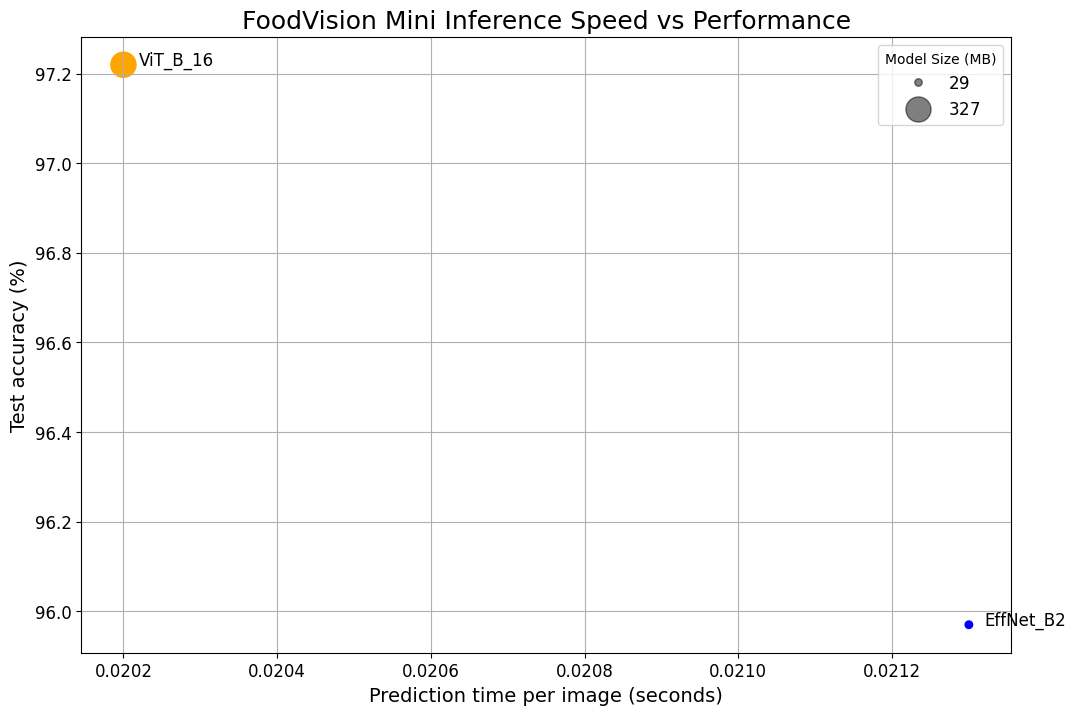

In [80]:
fig, axes = plt.subplots(figsize = (12, 8))
scatter = axes.scatter(data = dataframe,
                       x = "time_per_pred_cpu",
                       y = "test_acc",
                       c = ["Blue", "Orange"],
                       s = "model_size (MB)")

axes.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
axes.set_xlabel("Prediction time per image (seconds)", fontsize=14)
axes.set_ylabel("Test accuracy (%)", fontsize=14)
axes.tick_params(axis='both', labelsize=12)
axes.grid(True)

for index, row in dataframe.iterrows():
    axes.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.00002, row["test_acc"]),
                size=12)

handles, labels = scatter.legend_elements(prop = "sizes", alpha = 0.5)
model_size_legend = axes.legend(handles,
                                labels,
                                loc = "upper right",
                                title = "Model Size (MB)",
                                fontsize = 12)

plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 6. Bringing FoodVision Mini to life by creating a Gradio demo

In [49]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00
Gradio version: 5.31.0


In [62]:
vit = vit.to("cpu")
next(iter(vit.parameters())).device

device(type='cpu')

#### Let's create a function called `predict()` to go from:

images to food -> ML model (EffNetB2) -> outputs (food class label, prediction time)


In [63]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  img = vit_transforms(img).unsqueeze(dim = 0)

  vit.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(vit(img), dim = 1)

  pred_labels_and_prob = {vit_classes[i]: round(float(pred_probs[0][i]), 2) for i in range(len(vit_classes))}

  end_time = timer()
  pred_time = round((end_time - start_time), 4)

  return pred_labels_and_prob, pred_time

In [64]:
import random
from PIL import Image

path_list = list(pathlib.Path("data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg"))
# random_image_path type is list
random_image_path = random.sample(path_list, k = 1)[0]
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

random_image_pred_labels_and_prob, random_image_pred_time = predict(image)
print(f"Prediction label and probability dictionary: \n{random_image_pred_labels_and_prob}")
print(f"Prediction time: {random_image_pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg

Prediction label and probability dictionary: 
{'pizza': 0.99, 'steak': 0.0, 'sushi': 0.0}
Prediction time: 0.4766 seconds


In [70]:
# create a list of example inputs to our Gradio demo
example_list = [[str(file_path)] for file_path in random.sample(path_list, k = 3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg']]

### 6.1 Building a Gradio Interface

In [72]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An ViT_B_16 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."


demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
7
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://363777e48c22b5d173.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Turning our FoodVision Mini Gradio Demo into a deployable app

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

#### 7.1 Creating a `demos` folder to store our FoodVision app file

In [55]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/food_vision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents = True, exist_ok = True)
else:
  foodvision_mini_demo_path.mkdir(parents = True, exist_ok = True)

#### 7.2 Creating a folder of example images to use with our FoodVision Mini demo

In [56]:
foodvision_mini_examples_path = Path(foodvision_mini_demo_path) / "examples"
foodvision_mini_examples_path.mkdir(parents = True, exist_ok = True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src = example, dst = destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/food_vision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/food_vision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/food_vision_mini/examples/2582289.jpg


In [57]:
example_list = [["examples/" + example]for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

#### 7.3 Moving our trained EFfNetB2 model to our FoodVision Mini demo directory

In [83]:
vitb16_foodvision_mini_model_path = "models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth"
vitb16_foodvision_mini_model_destination = foodvision_mini_demo_path / vitb16_foodvision_mini_model_path.split("/")[1]

try:
  print(f"[INFO] Attempting to {vitb16_foodvision_mini_model_path} to {vitb16_foodvision_mini_model_destination}")
  shutil.move(src = vitb16_foodvision_mini_model_path, dst = vitb16_foodvision_mini_model_destination)
  print("[INFO] Model move complete.")
except:
  print(f"[INFO] No model found at {vitb16_foodvision_mini_model_path}, perhaps its already been moved.")
  print(f"[INFO] Model exists at {vitb16_foodvision_mini_model_destination} : {vitb16_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth to demos/food_vision_mini/09_pretrained_vit_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


#### 7.4 Turning our EffNetB2 model into Python script (model.py)

In [84]:
%%writefile demos/food_vision_mini/model.py

import torch
import torch.nn as nn
import torchvision

def create_vitb16_model(num_classes : int = 3, seed : int = 42):
  weights = torchvision.models.ViT_B_16_Weights
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier(nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features = 1408, out_features = num_classes)
  ))

  return model, transforms

Overwriting demos/food_vision_mini/model.py


#### 7.5 Turning our FoodVision Mini Gradio app into a python script (app.py)

In [86]:
%%writefile demos/food_vision_mini/app.py
import gradio as gr
import os
import torch

from model import create_vitb16_model
from timeit import default_timer as timer
from typing import Tuple, Dict

classes = ["pizza", "steak", "sushi"]

vitb16, vitb16_transforms = create_vitb16_model(num_classes = len(classes))

vitb16.load_state_dict(torch.load(
    f = "09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth",
    map_location = torch.device("cpu")
))

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()
  img = vitb16_transforms(img).unsqueeze(0)

  vitb16.eval()
  with torch.inference_mode():
    y_logit = vitb16(img)
    y_prob = torch.softmax(y_logit, dim = 1)

  pred_labels_and_probs = {classes[i] : round(y_prob[0][i], 2) for i in range(len(classes))}


  end_time = timer()
  time = round(end_time - start_time, 5)

  return pred_labels_and_probs, time


title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [["examples/" + example] for example in os.listdir("examples")]


demo = gr.Interface(
    fn = predict,
    inputs = gr.Image(type = "pil"),
    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
               gr.Number(label = "Prediction Time (s)")],
    examples = example_list,
    title = title,
    description = description,
    article = article)

demo.launch()

Writing demos/food_vision_mini/app.py


#### 7.6 Creating a requirements file for FoodVision Mini (requirements.txt)

In [88]:
%%writefile demos/food_vision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/food_vision_mini/requirements.txt
